# CC vs CP
## How do these charging paradigms change the DVA and ICA on cell level

In [1]:
import os
import sys
import math
sys.path.append(os.path.join(os.getcwd().partition('Code')[0], "Code"))
from src.config_base import GeneralConfig

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from matplotlib.ticker import FormatStrFormatter
import matplotlib.gridspec as gridspec
from matplotlib.ticker import AutoMinorLocator, FixedLocator

In [3]:
from src.data.read_pickle import ReadPickle
from src.filtering.filter_methods import FilterMethods
from src.voltage_capacity_analysis.ica import ICA
from src.voltage_capacity_analysis.dva import DVA
from src.visualization.config_visualization import VisualizationConfig, instantiate_matplotlib_parameters, cm2inch
instantiate_matplotlib_parameters()
from src.visualization.colormaps import ColorMaps

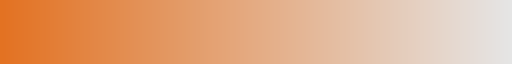

In [4]:
tum_orange_cmap = ColorMaps.orange_tum()
orange_colors = tum_orange_cmap(np.linspace(0,1, 10))
tum_orange_cmap

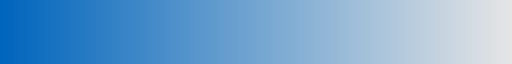

In [5]:
tum_blue_cmap = ColorMaps.blue_tum()
blue_colors = tum_blue_cmap(np.linspace(0,1, 10))
tum_blue_cmap

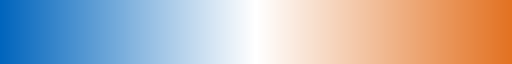

In [6]:
tum_cmap = ColorMaps.blue_orange_tum(grayscale=1)
colors = tum_cmap(np.linspace(0,1, 5))
tum_cmap

## Read Cell File

In [7]:
path2files = os.path.join(GeneralConfig.path2data.value,"VW","cell")

In [8]:
def filter_func_preprocess_U(signal):
    perc_filter = 0.1/100 * len(signal) #% filter
    filtered_signal = FilterMethods().rolling_mean_df(signal,window_size=FilterMethods().round_to_next_odd_number(perc_filter))
    #filtered_signal = FilterMethods().savgol(signal,window_size=FilterMethods().round_to_next_odd_number(perc_filter/100 * len(signal)))
    return filtered_signal

In [9]:
def filter_func_preprocess_Q(signal):
    perc_filter = 0.1/100 * len(signal) #% filter
    filtered_signal = FilterMethods().rolling_mean_df(signal,window_size=FilterMethods().round_to_next_odd_number(perc_filter))
    #filtered_signal = FilterMethods().savgol(signal,window_size=FilterMethods().round_to_next_odd_number(perc_filter/100 * len(signal)))
    return filtered_signal

In [10]:
read_pickle = ReadPickle()
read_pickle.set_filter_U(filter_func_preprocess_U)
read_pickle.set_filter_Q(filter_func_preprocess_Q)

In [11]:
df_cc =  read_pickle.read(os.path.join(path2files,"VW_LG_78Ah_NMC_20deg_CC_C45.pkl"))
df_cc_c6 =  read_pickle.read(os.path.join(path2files,"VW_LG_78Ah_NMC_20deg_CC_C6.pkl"))

In [12]:
df_cp =  read_pickle.read(os.path.join(path2files,"VW_LG_78Ah_NMC_20deg_CP_C45.pkl"))
df_cp_c6 =  read_pickle.read(os.path.join(path2files,"VW_LG_78Ah_NMC_20deg_CP_C6.pkl"))

### Cell DVA/ICA

In [13]:
def filter_func(signal):
    perc_filter = 0.5 #% filter
    filtered_signal = FilterMethods().rolling_mean_numpy(signal,window_size=FilterMethods().round_to_next_odd_number(perc_filter/100 * len(signal)))
    filtered_signal_reverse = FilterMethods().rolling_mean_numpy(np.flip(signal),window_size=FilterMethods().round_to_next_odd_number(perc_filter/100 * len(signal)))
    return (filtered_signal+np.flip(filtered_signal_reverse))/2

In [14]:
dva_extractor = DVA()
dva_extractor.set_filter(filter_func)
dva_cc, cap_cc =dva_extractor.get_dva(time=df_cc["time_h"], capacity=df_cc["Q"], voltage=df_cc["U"],crop_cap_Ah=(0,80.5))
dva_cp, cap_cp =dva_extractor.get_dva(time=df_cp["time_h"], capacity=df_cp["Q"], voltage=df_cp["U"],crop_cap_Ah=(0,80.5))

dva_cc_c6, cap_cc_c6 =dva_extractor.get_dva(time=df_cc_c6["time_h"], capacity=df_cc_c6["Q"], voltage=df_cc_c6["U"],crop_cap_Ah=(0,79.5))
dva_cp_c6, cap_cp_c6 =dva_extractor.get_dva(time=df_cp_c6["time_h"], capacity=df_cp_c6["Q"], voltage=df_cp_c6["U"],crop_cap_Ah=(0,79.5))

In [15]:
ica_extractor = ICA()
ica_extractor.set_filter(filter_func)
ica_cc, volt_cc = ica_extractor.get_ica(time=df_cc["time_h"], capacity=df_cc["Q"], voltage=df_cc["U"],crop_volt_V=(2.8,4.2))
ica_cp, volt_cp = ica_extractor.get_ica(time=df_cp["time_h"], capacity=df_cp["Q"], voltage=df_cp["U"],crop_volt_V=(2.8,4.2))

ica_cc_c6, volt_cc_c6 = ica_extractor.get_ica(time=df_cc_c6["time_h"], capacity=df_cc_c6["Q"], voltage=df_cc_c6["U"],crop_volt_V=(2.8,4.2))
ica_cp_c6, volt_cp_c6 = ica_extractor.get_ica(time=df_cp_c6["time_h"], capacity=df_cp_c6["Q"], voltage=df_cp_c6["U"],crop_volt_V=(2.8,4.2))

## Plot C/45 & C/6

In [16]:
def I_C45(axes,df_cc,df_cp):  
    axes.plot(df_cc["time_h"],df_cc["I"],color=colors[0])
    axes.plot(df_cp["time_h"]+1,df_cp["I"],color=colors[1],linestyle="--")
    
    axes.set_ylabel(r"Cell current in A",fontsize=9)
    axes.set_xlabel(r"Time in h",fontsize=9)
    
    axes.set_ylim([0,6])
    axes.set_xlim([0,45])
    
    tick_positions = np.array([0,2,4,6])
    axes.set_yticks(tick_positions)
    #axes.yaxis.set_major_formatter(FormatStrFormatter(r'%.1f'))
    axes.yaxis.set_minor_locator(FixedLocator([1,3,5]))
    tick_positions = np.array([0,15,30,45])
    axes.set_xticks(tick_positions)
    
    axes.grid(which="both")
    axes.set_axisbelow(True)
    return axes

In [17]:
def I_C6(axes, df_cc_c6, df_cp_c6):  
    axes.plot(df_cc_c6["time_h"],df_cc_c6["I"],color=colors[-1])
    axes.plot(df_cp_c6["time_h"]+0.1,df_cp_c6["I"],color=colors[-2],linestyle="--")
    
    axes.set_ylabel(r"Cell current in A",fontsize=9)
    axes.set_xlabel(r"Time in h",fontsize=9)
    
    axes.set_ylim([10,16])
    axes.set_xlim([0,6])
    
    tick_positions = np.array([10,12,14,16])
    axes.set_yticks(tick_positions)
    #axes.yaxis.set_major_formatter(FormatStrFormatter(r'%.1f'))
    axes.yaxis.set_minor_locator(FixedLocator([11,13,15]))
    tick_positions = np.array([0,2,4,6])
    axes.set_xticks(tick_positions)
    
    axes.grid(which="both")
    axes.set_axisbelow(True)
    return axes

In [18]:
def pOCV(axes,df_cc,df_cp, df_cc_c6, df_cp_c6):
    #0.1 for better vis
    axes.plot(df_cc["Q"]+0.1,df_cc["U"],color=colors[0])
    axes.plot(df_cp["Q"]+0.1,df_cp["U"],color=colors[1],linestyle="--")
    
    axes.plot(df_cc_c6["Q"]+0.1,df_cc_c6["U"],color=colors[-1])
    axes.plot(df_cp_c6["Q"]+0.1,df_cp_c6["U"],color=colors[-2],linestyle="--")
    
    axes.set_ylabel(r"Cell voltage in V",fontsize=9)
    axes.set_xlabel(r"Cell charge in Ah",fontsize=9)
    
    axes.set_ylim([2.8,4.2])
    axes.set_xlim([0,80])
    
    tick_positions = np.array([2.8,3.0,3.4,3.8,4.2])
    axes.set_yticks(tick_positions)
    axes.yaxis.set_minor_locator(FixedLocator([3.2,3.6,4.0]))
    tick_positions = np.array([0,20,40,60,78])
    axes.set_xticks(tick_positions)
    axes.xaxis.set_minor_locator(FixedLocator([10,30,50,70]))
    
    axes.grid()
    axes.set_axisbelow(True)
    return axes

In [19]:
def Error_U(axes,df_cc,df_cp, df_cc_c6, df_cp_c6):
    #C/45
    df_cc = df_cc[df_cc["U"]>=2.8] # 2.8 is the lower bound after relax and so the delta Capa must be aligned to zero again
    df_cc["Q"] = df_cc["Q"].values-df_cc["Q"].min()
    df_c45 = pd.merge_asof(left=df_cc,right=df_cp, on ="Q") # dataframes must be aliged on the Q signal or else errors are evaluted by shifted signals
    df_c45.dropna(subset=["U_x","U_y"], inplace=True)
    error = (df_c45["U_y"].values-df_c45["U_x"].values)*1000
    print(np.mean(np.abs(error)))
    # C/6
    df_cc_c6 = df_cc_c6[df_cc_c6["U"]>=3.02] # 3.02 is the lower bound after relax and so the delta Capa must be aligned to zero again
    df_cc_c6["Q"] = df_cc_c6["Q"].values-df_cc_c6["Q"].min()
    df_c6 = pd.merge_asof(left=df_cc_c6,right=df_cp_c6, on ="Q") # dataframes must be aliged on the Q signal or else errors are evaluted by shifted signals
    df_c6.dropna(subset=["U_x","U_y"], inplace=True)
    error_c6 = (df_c6["U_y"].values-df_c6["U_x"].values)*1000
    print(np.mean(np.abs(error_c6)))
    axes.plot(df_c45["Q"]-0.1,error,color=colors[0]) #-0.1 better vis
    axes.plot(df_c6["Q"]-0.1,error_c6,color=colors[-1])
    
    axes.set_ylabel(r"$\Delta U$ in mV",fontsize=9)
    axes.set_xlabel(r"Cell charge in Ah",fontsize=9)
    
    axes.set_ylim([-10,10])
    axes.set_xlim([0,80])
    
    tick_positions = np.array([-10,-5,0,5,10])
    axes.set_yticks(tick_positions)
    tick_positions = np.array([0,20,40,60,78])
    axes.set_xticks(tick_positions)
    axes.xaxis.set_minor_locator(FixedLocator([10,30,50,70]))
    
    axes.grid()
    axes.set_axisbelow(True)
    return axes

In [20]:
def DVA(axes,cap_cc,dva_cc,cap_cp,dva_cp,cap_cc_c6,dva_cc_c6,cap_cp_c6,dva_cp_c6):
    Q_nom = 78
    axes.plot(cap_cc,dva_cc*Q_nom,color=colors[0],linewidth=1)
    axes.plot(cap_cp,dva_cp*Q_nom,color=colors[1],linestyle="--",linewidth=1)
    
    axes.plot(cap_cc_c6,dva_cc_c6*Q_nom,color=colors[-1],linewidth=1)
    axes.plot(cap_cp_c6,dva_cp_c6*Q_nom,color=colors[-2],linestyle="--",linewidth=1)
    
    axes.set_ylabel(r"$Q_{cell}\ \cdot \ \frac{dU_{cell}}{dQ_{cell}}$ in V",fontsize=9)
    axes.set_xlabel(r"Cell charge in Ah",fontsize=9) 
    
    axes.set_ylim([0,2])
    tick_positions = np.array([0,0.5,1.0,1.5,2.0])
    axes.set_yticks(tick_positions)
    axes.set_xlim([0,80])
    tick_positions = np.array([0,20,40,60,78])
    axes.set_xticks(tick_positions)
    axes.xaxis.set_minor_locator(FixedLocator([10,30,50,70]))
    
    axes.grid()
    axes.set_axisbelow(True)
    
    # inset axes left
    axins = axes.inset_axes([22, 1.05, 17,0.8],transform = axes.transData) # [x0, y0, width, height]
    axins.plot(cap_cc,dva_cc*Q_nom,color=colors[0],linewidth=1)
    axins.plot(cap_cp,dva_cp*Q_nom,color=colors[1],linestyle="--",linewidth=1)
    
    axins.plot(cap_cc_c6,dva_cc_c6*Q_nom,color=colors[-1])
    axins.plot(cap_cp_c6,dva_cp_c6*Q_nom,color=colors[-2],linestyle="--",linewidth=1)
    # subregion of the original image
    x1, x2, y1, y2 = 8, 20.5,0.5,1.2
    axins.set_xlim(x1, x2)
    axins.set_ylim(y1, y2)
    axins.set_xticklabels([])
    axins.set_yticklabels([])
    axins.set_xticks([])
    axins.set_yticks([])
    #axins.grid()
    axes.indicate_inset_zoom(axins, edgecolor="black")

    # inset axes right
    axins2 = axes.inset_axes([55, 0.1, 17, 0.7],transform = axes.transData) # [x0, y0, width, height]
    axins2.plot(cap_cc,dva_cc*Q_nom,color=colors[0],linewidth=1)
    axins2.plot(cap_cp,dva_cp*Q_nom,color=colors[1],linestyle="--",linewidth=1)
    
    axins2.plot(cap_cc_c6,dva_cc_c6*Q_nom,color=colors[-1],linewidth=1)
    axins2.plot(cap_cp_c6,dva_cp_c6*Q_nom,color=colors[-2],linestyle="--",linewidth=1)
    # subregion of the original image
    x1, x2, y1, y2 = 44, 52,0.7,1.7
    axins2.set_xlim(x1, x2)
    axins2.set_ylim(y1, y2)
    axins2.set_xticklabels([])
    axins2.set_yticklabels([])
    axins2.set_xticks([])
    axins2.set_yticks([])
    #axins.grid()
    axes.indicate_inset_zoom(axins2, edgecolor="black")
    
    return axes

In [21]:
def ICA(axes,volt_cc,ica_cc,volt_cp,ica_cp, volt_cc_c6,ica_cc_c6,volt_cp_c6,ica_cp_c6):

    axes.plot(volt_cc,ica_cc,color=colors[0],linewidth=1)
    axes.plot(volt_cp,ica_cp,color=colors[1],linestyle="--",linewidth=1)
    
    axes.plot(volt_cc_c6,ica_cc_c6,color=colors[-1],linewidth=1)
    axes.plot(volt_cp_c6,ica_cp_c6,color=colors[-2],linestyle="--",linewidth=1)
    
    axes.set_ylabel(r"$\frac{dQ_{cell}}{dU_{cell}}$ in $\frac{Ah}{V}$",fontsize=9)
    axes.set_xlabel(r"Cell voltage in V",fontsize=9) 
    
    axes.set_ylim([0,250])
    tick_positions = np.array([0,50,100,150,200,250])
    axes.set_yticks(tick_positions)
    axes.set_xlim([2.8,4.2])
    tick_positions = np.array([2.8,3.0,3.4,3.8,4.2])
    axes.set_xticks(tick_positions)
    axes.xaxis.set_minor_locator(FixedLocator([3.2,3.6,4.0]))
    
    axes.grid()
    axes.set_axisbelow(True)
    
    # inset axes left
    axins = axes.inset_axes([3.05, 75, 0.3,140],transform = axes.transData) # [x0, y0, width, height]
    axins.plot(volt_cc,ica_cc,color=colors[0],linewidth=1)
    axins.plot(volt_cp,ica_cp,color=colors[1],linestyle="--",linewidth=1)
    
    axins.plot(volt_cc_c6,ica_cc_c6,color=colors[-1],linewidth=1)
    axins.plot(volt_cp_c6,ica_cp_c6,color=colors[-2],linestyle="--",linewidth=1)
    # subregion of the original image
    x1, x2, y1, y2 = 3.42, 3.58,55,155
    axins.set_xlim(x1, x2)
    axins.set_ylim(y1, y2)
    axins.set_xticklabels([])
    axins.set_yticklabels([])
    axins.set_xticks([])
    axins.set_yticks([])
    #axins.grid()
    axes.indicate_inset_zoom(axins, edgecolor="black")

    # inset axes right
    axins2 = axes.inset_axes([3.83, 140, 0.3, 100],transform = axes.transData) # [x0, y0, width, height]
    axins2.plot(volt_cc,ica_cc,color=colors[0],linewidth=1)
    axins2.plot(volt_cp,ica_cp,color=colors[1],linestyle="--",linewidth=1)
    
    axins2.plot(volt_cc_c6,ica_cc_c6,color=colors[-1],linewidth=1)
    axins2.plot(volt_cp_c6,ica_cp_c6,color=colors[-2],linestyle="--",linewidth=1)
    # subregion of the original image
    x1, x2, y1, y2 = 3.7, 3.83,44,120
    axins2.set_xlim(x1, x2)
    axins2.set_ylim(y1, y2)
    axins2.set_xticklabels([])
    axins2.set_yticklabels([])
    axins2.set_xticks([])
    axins2.set_yticks([])
    #axins.grid()
    axes.indicate_inset_zoom(axins2, edgecolor="black")
    return axes

C:\Users\ga97req\AppData\Local\Temp\ipykernel_12940\995202094.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_cc["Q"] = df_cc["Q"].values-df_cc["Q"].min()
C:\Users\ga97req\AppData\Local\Temp\ipykernel_12940\995202094.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_cc_c6["Q"] = df_cc_c6["Q"].values-df_cc_c6["Q"].min()


1.0959219758025056
1.278266754414569


C:\Users\ga97req\AppData\Local\Temp\ipykernel_12940\3396886952.py:38: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


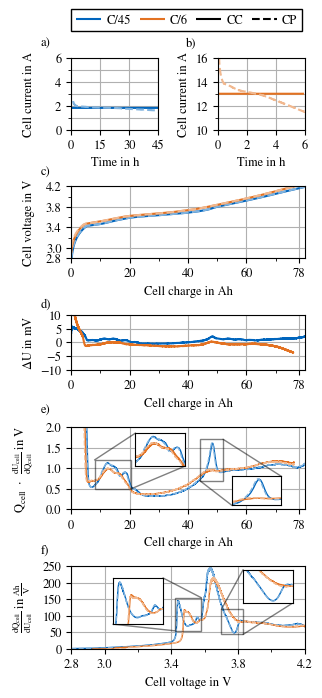

In [22]:
nrow = 4.2
fig= plt.figure(figsize=(VisualizationConfig.columnwidth_in_in.value,
                                nrow*cm2inch(4)),layout="constrained")
gs = gridspec.GridSpec(5, 2,height_ratios=[1.3, 1.3,1, 1.5,1.5])

axes_C45 = fig.add_subplot(gs[0, 0])
axes_C45 = I_C45(axes_C45,df_cc,df_cp)

axes_C6 = fig.add_subplot(gs[0, 1])
axes_C6 = I_C6(axes_C6,df_cc_c6,df_cp_c6)

axes_pocv = fig.add_subplot(gs[1, :])
axes_pocv = pOCV(axes_pocv,df_cc,df_cp,df_cc_c6,df_cp_c6)

axes_error = fig.add_subplot(gs[2, :])
axes_error = Error_U(axes_error,df_cc,df_cp,df_cc_c6,df_cp_c6)

axes_DVA = fig.add_subplot(gs[3, :])
axes_DVA = DVA(axes_DVA,cap_cc,dva_cc,cap_cp,dva_cp,
                      cap_cc_c6,dva_cc_c6,cap_cp_c6,dva_cp_c6)

axes_ICA = fig.add_subplot(gs[4, :])
axes_ICA = ICA(axes_ICA,volt_cc,ica_cc,volt_cp,ica_cp,
             volt_cc_c6,ica_cc_c6,volt_cp_c6,ica_cp_c6)

handles, labels =axes_ICA.get_legend_handles_labels()  
line = plt.hlines(0,0,1,label=r'C/45',color=colors[0])
line2 = plt.hlines(0,0,1,label=r'C/6', color=colors[-1])
line3 = plt.hlines(0,0,1,label=r'CC',color="black")
line4 = plt.hlines(0,0,1,label=r'CP', color="black",linestyle="--")
# add manual symbols to auto legend
handles.extend([line, line2, line3,line4])
lgd = fig.legend(handles=handles,loc="center",fontsize=9,ncols=4,handletextpad=0.4,
           framealpha =1 , fancybox=False,labelspacing=0.5,columnspacing=0.7,edgecolor="black",bbox_to_anchor=(0.577,1.03))

fig.align_ylabels([axes_C45,axes_pocv,axes_error,axes_DVA,axes_ICA])

plt.tight_layout()
axes_C45.text(-0.3, 1.2, r'a)', horizontalalignment='center', fontsize=9,
     verticalalignment='center', transform=axes_C45.transAxes)
axes_C6.text(-0.3, 1.2, r'b)', horizontalalignment='center',fontsize=9,
     verticalalignment='center', transform=axes_C6.transAxes)
axes_pocv.text(-0.11, 1.2, r'c)', horizontalalignment='center',fontsize=9,
     verticalalignment='center', transform=axes_pocv.transAxes)
axes_error.text(-0.11,1.2, r'd)', horizontalalignment='center',fontsize=9,
     verticalalignment='center', transform=axes_error.transAxes)
axes_DVA.text(-0.11, 1.2, r'e)', horizontalalignment='center',fontsize=9,
     verticalalignment='center', transform=axes_DVA.transAxes)
axes_ICA.text(-0.11, 1.2, r'f)', horizontalalignment='center',fontsize=9,
     verticalalignment='center', transform=axes_ICA.transAxes)
fig.savefig(os.path.join(GeneralConfig.path2figures.value,"01-POCV_DVA_ICA_VW_CC_vs_CP_crate_comp.pdf"),bbox_extra_artists=([lgd]),bbox_inches="tight")
fig.savefig(os.path.join(GeneralConfig.path2figures.value,"01-POCV_DVA_ICA_VW_CC_vs_CP_crate_comp.png"),dpi=300,bbox_inches="tight")